In [7]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep Learning Analysis

In [8]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [9]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

In [10]:
with open('results/02/results.txt', 'r') as file:
    best_ae_model_path = file.readline().strip()

In [11]:
with open('results/02/best_trial_params.json', 'r') as json_file:
    best_model_params = json.load(json_file)

print(best_model_params)

{'latent_size': 39, 'n_layers': 3, 'dropout': 0.0031343232927195652}


In [12]:
cancer_autoencoder = CancerDataAutoEncoder.load_from_checkpoint(
    best_ae_model_path,
    **best_model_params
)

In [13]:
import random


class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU):
        super(SimpleNN, self).__init__()
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.network(x)

simple_nn = SimpleNN(
    input_dim=best_model_params['latent_size'],
    n_layers=8
)

In [14]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(BaseCancerRegressor(cancer_autoencoder, simple_nn), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCancerRegressor                      [1, 1]                    --
├─CancerDataAutoEncoder: 1-1             --                        88,292
│    └─Sequential: 2-1                   [1, 39]                   --
│    │    └─Linear: 3-1                  [1, 149]                  (30,396)
│    │    └─ReLU: 3-2                    [1, 149]                  --
│    │    └─Dropout: 3-3                 [1, 149]                  --
│    │    └─Linear: 3-4                  [1, 95]                   (14,250)
│    │    └─ReLU: 3-5                    [1, 95]                   --
│    │    └─Dropout: 3-6                 [1, 95]                   --
│    │    └─Linear: 3-7                  [1, 41]                   (3,936)
│    │    └─ReLU: 3-8                    [1, 41]                   --
│    │    └─Dropout: 3-9                 [1, 41]                   --
│    │    └─Linear: 3-10                 [1, 39]                

In [15]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = BaseCancerRegressor(
        cancer_autoencoder,
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=3,
            dropout=.3,
            activation=nn.LeakyReLU,
        ),
        lr=0.003,
        weight_decay=0.004,
        optimizer=torch.optim.Adam,
    )
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEnc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [16]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    452.19085693359375     │
│         test_mse          │    452.19085693359375     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 452.19085693359375, 'test_mse': 452.19085693359375}]

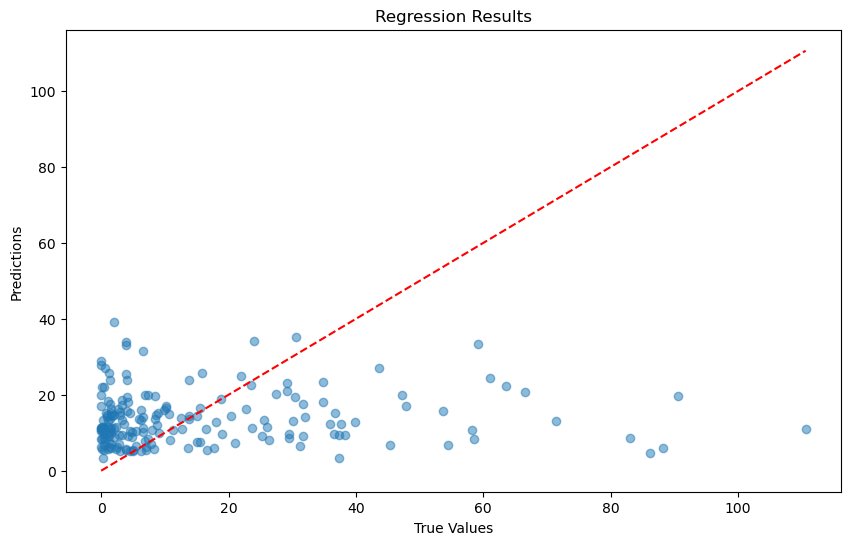

In [17]:
def plot_regression_results(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = model(x)
            y_true.append(y)
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Results')
    plt.show()
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())

In [21]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 10)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model = BaseCancerRegressor(
        CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=n_layers,
            dropout=dropout,
            activation=activation,
        ),
        lr=learning_rate,
        weight_decay=weight_decay,
        optimizer=optimizer,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"trial_{trial.number}", max_epochs=100, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [22]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="regressor_study")
study.optimize(objective, n_trials=50, n_jobs=-1)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-14 14:26:45,867] A new study created in memory with name: regressor_study
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experiment

: 